In [1]:
from alignscore import AlignScore
from tqdm.notebook import tqdm
import numpy as np
import json
import torch
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
models = ['samsum_bart_base', 'samsum_bart_cleaned', 'samsum_bart_custom_tokenizer', 'samsum_bart_oov', 'samsum_bart_wsd', 'samsum_bart_wsd_custom_tokenizer', 'samsum_bart_oov_custom_tokenizer']

In [3]:
#load the summaries
summaries = {}
for model in models:
    with open(f"../models/{model}/summaries.json", "r") as f:
        summaries[model] = json.load(f)

In [3]:
scorer = AlignScore(model='roberta-base', batch_size=32, device='cuda', ckpt_path='./AlignScore-base.ckpt', evaluation_mode='nli_sp')

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Lightning automatically upgraded your loaded checkpoint from v1.7.7 to v1.9.5. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file x:\UniBielefeld\Sprachverarbeitung\factuality\AlignScore-base.ckpt`
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [24]:
def get_scores(model, scorer: AlignScore) -> list[float]:
    scores = {'true_summary_score': [], 'generated_summary_score': []}
    dialogues = summaries[model]['dialogue']
    true_claims = summaries[model]['summary']
    generated_claims = summaries[model]['generated_summaries']
    
    scores['true_summary_score'] = scorer.score(contexts=dialogues, claims=true_claims)
    scores['generated_summary_score'] = scorer.score(contexts=dialogues, claims=generated_claims)
    
    return scores

In [26]:

scores = {}
for model in models:
    scores[model] = get_scores(model, scorer)

Evaluating: 100%|██████████| 819/819 [00:35<00:00, 23.14it/s]


In [4]:
#load the scores from disk
with open("../models/alignscores.json", "r") as f:
    import json
    scores = json.load(f)

In [27]:
#save the scores
def save_scores(scores):
    with open("../models/alignscores.json", "w") as f:
        import json
        json.dump(scores, f)

In [30]:
# Create DataFrames for the scores
def plot_scores(scores, model_name):
    df_true = pd.DataFrame(scores[model_name]['true_summary_score'], columns=["True Summary"])
    df_generated = pd.DataFrame(scores[model_name]['generated_summary_score'], columns=["Generated Summary"])

    # Calculate the mean scores
    mean_true = df_true['True Summary'].mean()
    mean_generated = df_generated['Generated Summary'].mean()

    # Plot the KDEs on the same plot
    ax = df_true.plot(kind="kde", color='blue', linestyle='-', label='True Summary', legend=True)
    df_generated.plot(kind="kde", ax=ax, color='red', linestyle='--', label='Generated Summary', legend=True)

    # Add vertical lines for the mean scores
    plt.axvline(mean_true, color='blue', linestyle='-', linewidth=1)
    plt.axvline(mean_generated, color='red', linestyle='--', linewidth=1)

    # Add text labels next to the vertical lines
    plt.text(plt.gca().get_xlim()[1]*0.95, plt.gca().get_ylim()[1]*0.8, f'Mean: {mean_true:.3f}', color='blue', rotation=0, va='top', ha='right')
    plt.text(plt.gca().get_xlim()[1]*0.95, plt.gca().get_ylim()[1]*0.7, f'Mean: {mean_generated:.3f}', color='red', rotation=0, va='top', ha='right')

    # Add labels and title
    plt.xlabel('Score')
    plt.ylabel('Density')
    plt.title(f'KDE of True and Generated Summary Scores for {model_name}')
    plt.grid(True)

    # Show the plot
    plt.show()

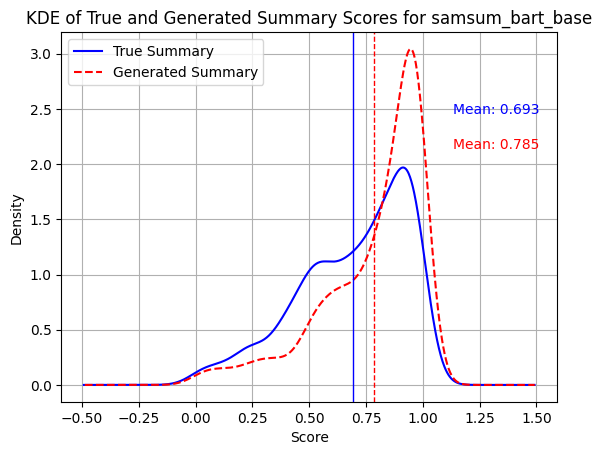

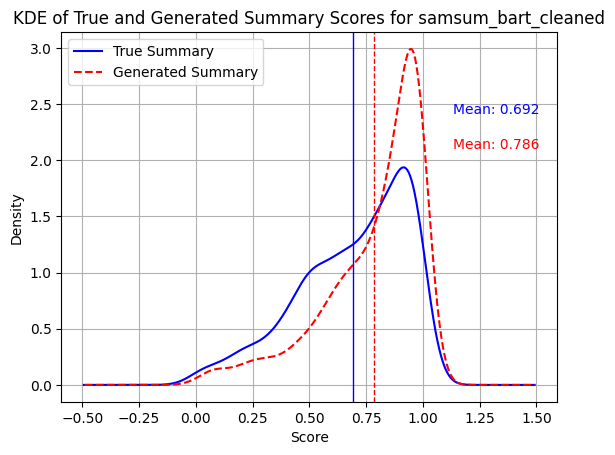

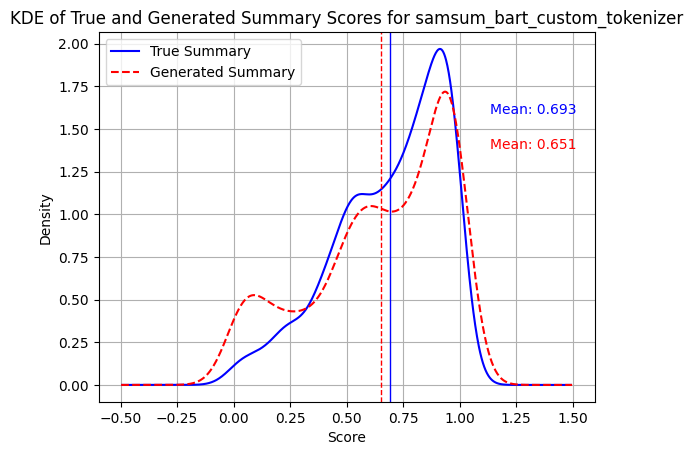

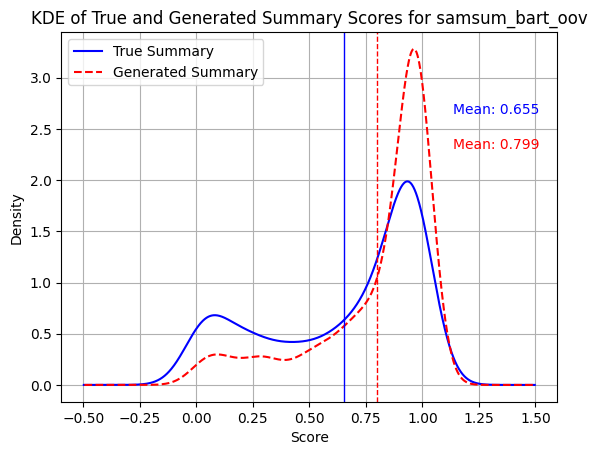

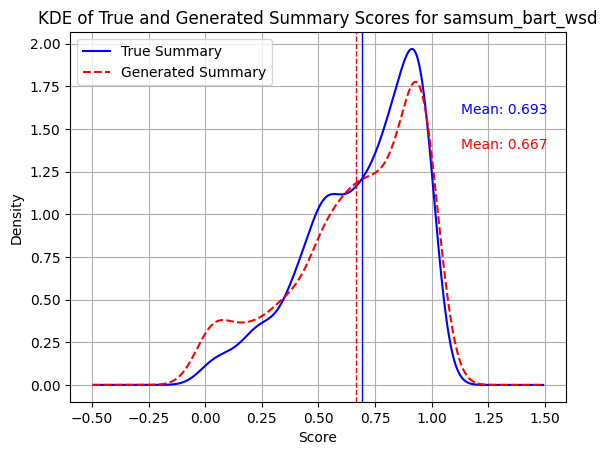

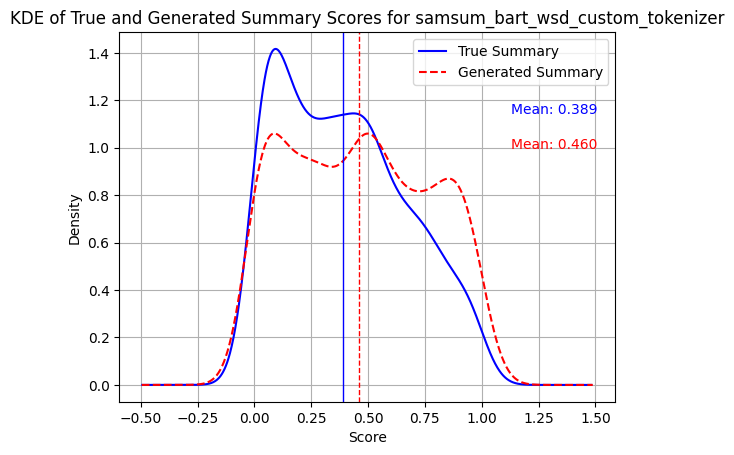

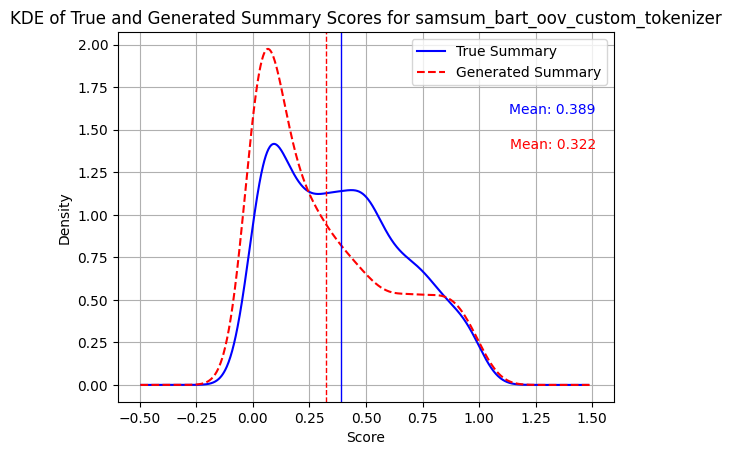

In [32]:
for model in models:
    plot_scores(scores, model)

In [35]:
def plot_scores_2(scores, model_names):
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    
    for model in model_names:
        df_generated = pd.DataFrame(scores[model]['generated_summary_score'], columns=[model])

        # Calculate the mean scores
        mean_generated = df_generated[model].mean()

        # Plot the KDEs on the same plot
        df_generated.plot(kind="kde", ax=ax, label=model, legend=True)

        # Add vertical lines for the mean scores
        # plt.axvline(mean_true, color='blue', linestyle='-', linewidth=1)
        # plt.axvline(mean_generated, color='red', linestyle='--', linewidth=1)

    # Add text labels next to the vertical lines
    # plt.text(plt.gca().get_xlim()[1]*0.95, plt.gca().get_ylim()[1]*0.8, f'Mean: {mean_true:.2f}', color='blue', rotation=0, va='top', ha='right')
    # plt.text(plt.gca().get_xlim()[1]*0.95, plt.gca().get_ylim()[1]*0.7, f'Mean: {mean_generated:.2f}', color='red', rotation=0, va='top', ha='right')

    # Add labels and title
    plt.xlabel('Score')
    plt.ylabel('Density')
    plt.title('KDE of True and Generated Summary Scores with Mean Lines')
    plt.grid(True)

    # Show the plot
    plt.show()

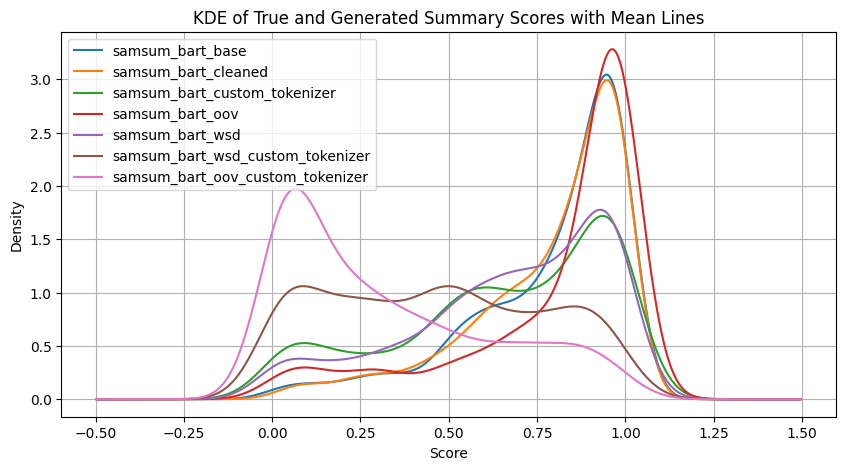

In [36]:
plot_scores_2(scores, models)

In [8]:
generated_scores = {model: scores[model]['generated_summary_score'] for model in models}

In [9]:
generated_scores_df = pd.DataFrame(generated_scores)

In [11]:
from scipy.stats import ttest_ind
def t_test_matrix_alignscore(models):
    t_test_results = []
    base_model = 'samsum_bart_base'

    for model in models:
        if model != base_model:
        
            # Extract ROUGE-1 F1 scores for the base model and the current model
            base_scores = generated_scores_df[base_model].dropna()
            model_scores = generated_scores_df[model].dropna()
            
            # Ensure that both series have the same length
            # If not, align them by index or handle accordingly
            min_length = min(len(base_scores), len(model_scores))
            base_scores = base_scores.iloc[:min_length]
            model_scores = model_scores.iloc[:min_length]
            
            # Perform the independent t-test (Welch's t-test)
            _, p_value = ttest_ind(base_scores, model_scores, equal_var=False)
            
            # Append the results to the list
            t_test_results.append({
                'Model': model,
                'P-value': p_value
            })

    # Create a DataFrame from the t-test results
    t_test_df = pd.DataFrame(t_test_results)

    return t_test_df

In [16]:
generated_scores_df.agg(['mean', 'std']).transpose().to_latex("alignscore.tex")

In [12]:
t_test_df = t_test_matrix_alignscore(models)

In [17]:
t_test_df

,Model,P-value
0,samsum_bart_cleaned,9.414284e-01
1,samsum_bart_custom_tokenizer,5.209869e-24
2,samsum_bart_oov,2.587826e-01
3,samsum_bart_wsd,1.076213e-20
4,samsum_bart_wsd_custom_tokenizer,2.485379e-113
5,samsum_bart_oov_custom_tokenizer,1.194556e-205


In [14]:
t_test_df.to_latex(index=False, buf="alignscore_ttest.tex")